In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

from matplotlib import gridspec
# %matplotlib

In [64]:
def readData(file):
    df = pd.read_csv(file, delimiter = '\t')
    columns = [label + " (%s)"%df[label].iloc[0] for label in df.keys()]
    df.columns = columns
    return df.drop(0).reset_index(drop = True).astype(float)

def getUnits(data):
    l = data.keys()[1]
    if 'u' in l: return 1e-6
    elif 'm' in l: return 1e-3
    else: raise(Exception('Units dont match'))
                
def getRegion(data, from_, to_):
    return (data['TIME (s)'] >= from_) & (data['TIME (s)'] <= to_)

def filterDataS(data, from_, to_):
    pos = getRegion(data, from_, to_)
    data['TIME (s)'][pos] = data['TIME (s)'][pos] - from_
    return data[pos]

def filterDataM(data, from_, to_):
    return filterDataS(data, from_ * 60, to_ * 60)

def makePlot(datas, labels = None, xlabel = 'Tiempo (minutos)', ylabel = 'Potencia', figsize = (8, 4.5), col = 1):
    fig, ax = plt.subplots(figsize = figsize)
    for i in range(len(datas)):
        data = datas[i]
        x = data['TIME (s)'] / 60
        y = data[data.keys()[col]]
        if labels != None:
            label = labels[i]
            ax.plot(x.values, y.values, label = label)
        else: 
            ax.plot(x.values, y.values)
        
    ax.plot([min(x), max(x)], [0,0], c = 'k', lw = 1)
            
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel + data.keys()[1][1:])
    
    if labels != None:
        ax.legend()
    
    fig.tight_layout()
    
    return fig, ax

def getBaseline(data, from_, to_, col = 1):
    from_ *= 60
    to_ *= 60
    data = data.copy()
    time = data['TIME (s)'].values
    from_ = abs(time - from_).argmin()
    to_ = abs(time - to_).argmin()
    tf = time[from_]
    tt = time[to_]
    y = data[data.keys()[col]]
    yf = y.loc[from_]
    yt = y.loc[to_]
    
    m = (yt - yf) / (tt - tf)
    b = yf - m * tf
    
    y = y - (m * time + b)
    
    data[data.keys()[col]] = y
    return data, m, b

def integrateData(data, from_, to_, m = 0, b = 0, col = 1):
    pos = getRegion(data, from_ * 60, to_ * 60)
    if m == 0 and b == 0:
        _, m, b = getBaseline(data, from_, to_, col = col)
    data = data[pos]
    t = data['TIME (s)']
    
    baseline = m * t + b
    y = data[data.keys()[col]]
    y = y - baseline
    dx = np.diff(t).mean()
    integral = np.trapz(y, dx = dx) # dx = 1 second
    return integral * getUnits(data), t / 60, y

def getMoles(c, v):
    return (c) * (v * 1e-6)

def getEnthalpy(heat, mols):
    return -(heat / mols) / 1000 # kJ / mol

def addIntegral(ax, v, t, y):
    ax.plot(t, y, '--', label = 'Ajustado')
    ax.fill_between(t, 0, y, alpha = 0.4, label = 'Q = %.2e J'%v)

# HCl

In [114]:
# HCl_1 = readData('1-HCl-KHCO3.txt')
HCl_2 = readData('2-HCl-KHCO3.txt')

HCl_2 = filterDataM(HCl_2, 0, 220)

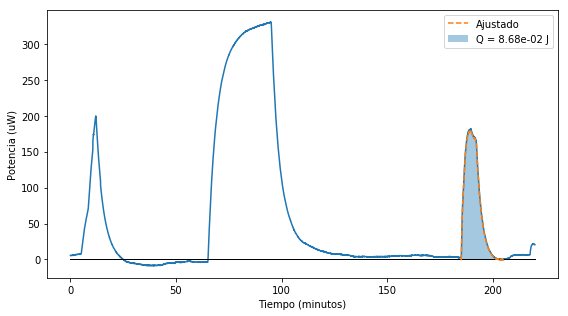

In [115]:
HCl_2c, m, b = getBaseline(HCl_2, 25, 205)

from_, to_ = 185, 205
_, m, b = getBaseline(HCl_2c, from_, to_)

fig, ax = makePlot([HCl_2c])

v, t, y = integrateData(HCl_2c, from_, to_)

addIntegral(ax, v, t, y)

ax.legend()

fig.savefig('HCl.png', dpi = 300)

plt.show()

In [119]:
V = 51.185 * 27 #uL
C = 0.2469 * 1e-3 # mM
# C = 0.0084
n = getMoles(C, V)
getEnthalpy(v, n) # kJ / mol

-254.44956715952378

In [120]:
print(n*1e6)

0.34121456550000007


# 1-Propanol

In [8]:
propanol_1 = readData('1-propanol_single.txt')
propanol_2 = readData('1-propanol_multiple.txt')

(<Figure size 576x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7820619748>)

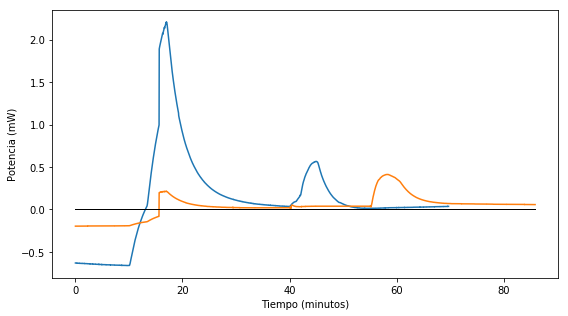

In [9]:
makePlot([propanol_1, propanol_2])

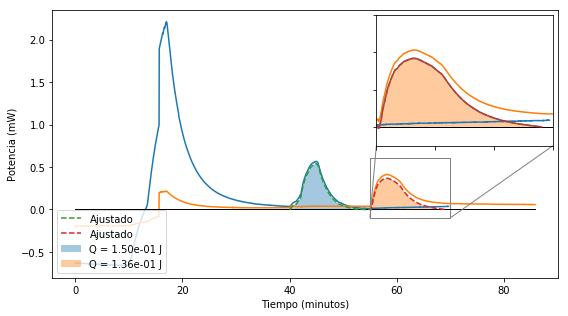

In [77]:
fig, ax = makePlot([propanol_1, propanol_2], col = 1)

v, t, y = integrateData(propanol_1, 40, 55, col = 1)
addIntegral(ax, v, t, y)

v2, t2, y2 = integrateData(propanol_2, 55, 69, col= 1)
addIntegral(ax, v2, t2, y2)

axins = zoomed_inset_axes(ax, 2.2, loc = 1) # zoom-factor: 2.5, location: upper-left

axins.plot([0, 70], [0,0], c = 'k', lw = 1)

axins.plot(propanol_1['TIME (s)'] / 60, propanol_1[propanol_1.keys()[1]])
axins.plot(propanol_2['TIME (s)'] / 60, propanol_2[propanol_2.keys()[1]])

axins.plot(t, y)
axins.plot(t2, y2)

addIntegral(axins, v, t, y)
addIntegral(axins, v2, t2, y2)

axins.set_xlim(55, 70) # apply the x-limits
axins.set_ylim(-1e-1, 0.6) # apply the y-limits

plt.yticks(visible = False)
plt.xticks(visible = False)

mark_inset(ax, axins, loc1 = 3, loc2 = 4, fc = "none", ec = "0.5")

ax.legend(loc = 3)
plt.show()
fig.savefig('singlePropanol.png', dpi = 300)

In [109]:
rho = 0.993487
V = 51.185 * 27 # uL
P = 2.96e-2
m = 60.10

n = (P * rho * (V * 1e-3)) / m

(v / n)

221.4529906109183

In [110]:
rho = 0.993487
V = 51.185 * 27 # uL
P = 2.96e-2
m = 60.10

n = (P * rho * (V * 1e-3)) / m

(v2 / n)

200.6383422089879

# Saturated

In [9]:
propanolC = readData('1-propanol_c.txt')
propanolC = filterDataM(propanolC, 100, 600)

pos = getRegion(propanolC, 202.2 * 60, 202.8 * 60)

propanolC[propanolC.keys()[1]][pos] = 0.148 

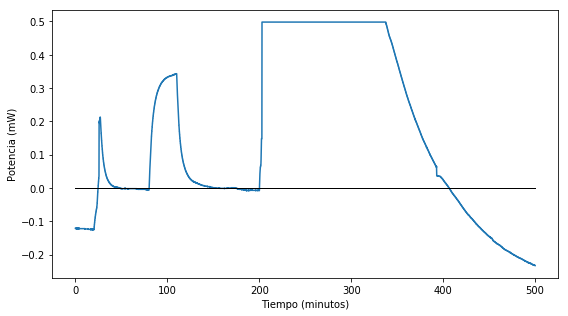

In [10]:
fig, ax = makePlot([propanolC], None)

fig.savefig('concentratedPropanol.png', dpi = 300)

# Multiple

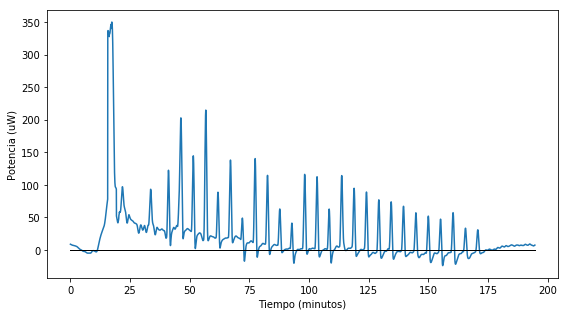

In [19]:
propanol_m = readData('1-propanol_multiple2.txt')

propanol_m, m, b = getBaseline(propanol_m, 95, 175, col = 3)
makePlot([propanol_m], col = 3)

plt.savefig('multiple.png', dpi = 300)

In [26]:
limits = [(32.6219, 34.8848),
         (40.1428, 41.7314),
         (44.8065, 47.1854),
         (50.6788, 52.2035),
         (55.7610, 57.5821),
         (60.8856, 62.5373),
         (66.1766, 67.7538),
         (71.2461, 72.7106),
         (76.3912, 78.1819),
         (81.6352, 83.4258),
         (86.6874, 88.4780),
         (91.8674, 93.5301),
         (97.1114, 98.9660),
         (102.227, 104.338),
         (107.535, 109.198),
         (112.659, 115.365),
         (117.880, 119.684),
         (123.073, 124.932),
         (128.267, 130.126),
         (133.213, 135.286),
         (138.202, 140.470),
         (143.312, 145.913),
         (149.023, 150.773),
         (153.559, 155.957),
         (159.197, 161.27),
         (164.381, 166.519),
         (169.305, 171.184)]

In [103]:
integrals = np.array([integrateData(propanol_m, t0, t1, col = 3)[0] for (t0, t1) in limits]) * 1e3

In [104]:
x = np.arange(len(integrals))
integrals *= -1
(m, b), cov = np.polyfit(x, integrals, 1, cov = 1)
dm = cov[0, 0]**0.5
db = cov[1, 1]**0.5

print(m, dm, b, db)

y = m * x + b

(m2, b2), cov = np.polyfit(x[15:], integrals[15:], 1, cov = 1)
dm2 = cov[0, 0]**0.5
db2 = cov[1, 1]**0.5

y2 = m2 * x + b2
print(m2, dm2, b2, db2)

0.13872615241679737 0.05054611564995457 -6.426485705388452 0.7660141115385805
0.3226834399547675 0.048576754082605374 -10.397878723615296 1.0098436173870828


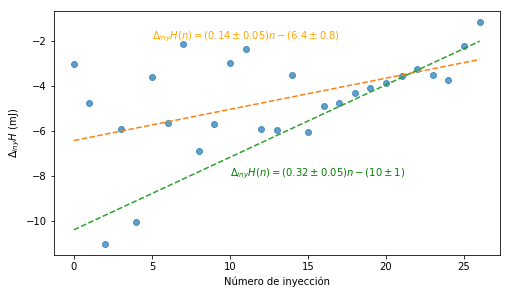

In [105]:
fig, ax = plt.subplots(figsize = (8, 4.5))
ax.plot(x, integrals, 'o', alpha = 0.7)
ax.plot(x, y, '--')
ax.plot(x, y2, '--')

ax.set_xlabel('Número de inyección')
ax.set_ylabel(r'$\Delta_{iny}H$ (mJ)')

ax.text(5, -1.9, '$\Delta_{iny}H(n) = (0.14 \pm 0.05)n - (6.4 \pm 0.8)$', color = 'orange')

ax.text(10, -8, '$\Delta_{iny}H(n) = (0.32 \pm 0.05)n - (10 \pm 1)$', color = 'g')


fig.savefig('multipleInt.png', dpi = 300)
plt.show()

In [111]:
0.1387e-3 / n

0.20511176019448402

In [112]:
0.32263e-3 / n

0.47711036187127887